# Time series forecasting with Tensorflow and Aeon

In [1]:
import tensorflow as tf
from scikeras.wrappers import KerasRegressor

from matplotlib import pyplot as plt
from aeon.forecasting.compose import make_reduction
from aeon.datasets import load_airline
from aeon.utils.plotting import plot_series
import numpy as np
from aeon.forecasting.model_selection import temporal_train_test_split

In [2]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
# we will try to forecast y_test from y_train
fh = np.arange(len(y_test)) + 1

In [3]:
def get_clf_model(hidden_layer_sizes, meta, compile_kwargs):

    model = tf.keras.Sequential()
    input_layer = tf.keras.layers.Input(shape=(meta["n_features_in_"]))
    model.add(input_layer)

    for i, hidden_layer_size in enumerate(hidden_layer_sizes):
        hidden_layer = tf.keras.layers.Dense(
            units=hidden_layer_size, activation="relu", name=f"hidden{i+1}"
        )
        model.add(hidden_layer)

    output_layer = tf.keras.layers.Dense(units=1, name="output")
    model.add(output_layer)

    model.compile(
        optimizer=compile_kwargs["optimizer"],
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.mean_absolute_percentage_error],
    )

    return model

In [4]:
tf.keras.backend.clear_session()
tf.keras.backend.set_epsilon(1)

In [5]:
clf = KerasRegressor(
    model=get_clf_model,
    hidden_layer_sizes=(16,),
    optimizer="adam",
    optimizer__learning_rate=0.001,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
)

In [6]:
forecaster = make_reduction(clf, window_length=20, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh)

Epoch 1/200
5/5 [==============================] - 1s 71ms/step - loss: 105644.8750 - mean_absolute_percentage_error: 139.4859 - val_loss: 213845.2969 - val_mean_absolute_percentage_error: 126.3394
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 76303.2734 - mean_absolute_percentage_error: 118.5629 - val_loss: 153063.4844 - val_mean_absolute_percentage_error: 105.7903
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 53999.6719 - mean_absolute_percentage_error: 98.7085 - val_loss: 105841.2578 - val_mean_absolute_percentage_error: 86.5717
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 36531.2383 - mean_absolute_percentage_error: 80.2955 - val_loss: 71712.1641 - val_mean_absolute_percentage_error: 69.4946
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 24176.3242 - mean_absolute_percentage_error: 63.9740 - val_loss: 47630.6875 - val_mean_absolute_percentage_error: 54.3750
Epoch 6/200
5/5 [=========

In [7]:
forecaster

RecursiveTabularRegressionForecaster(estimator=KerasRegressor(batch_size=16, epochs=200, hidden_layer_sizes=(16,), model=<function get_clf_model at 0x0000018048DCAF20>, optimizer='adam', optimizer__learning_rate=0.001, validation_split=0.2),
                                     window_length=20)

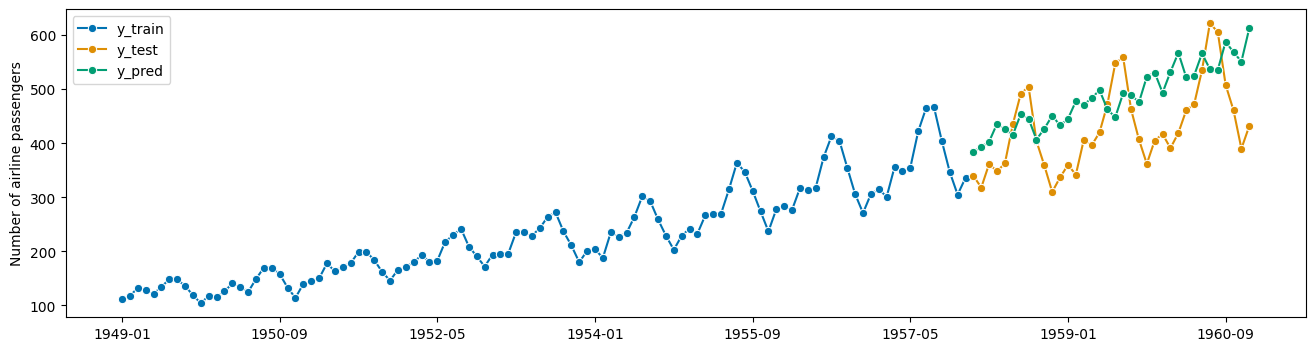

In [8]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()